In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os, time, stat, io
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')

# Model Notes
- Questions
    - How will we know if the lock down is working? early signals from acceleration in hospitalization
    
- Things to do with cohort model:
    - Compliance levels
    - Monte carlo
    - vary hospital duration by icu/non-icu
    - vary asymptomatic transmission vs symptomatic
    - Add recovered line
    - functionalize charts
    - Functionalize the mortality rate by hospital capacity.

# Data Ingestion

## Bring in county reporting data

In [3]:
raw_reporting = pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv')
df_reporting = raw_reporting
df_reporting['dt'] = pd.to_datetime(df_reporting.date)
df_reporting = df_reporting.set_index(['dt','state','county']).sort_index()
df_reporting.reorder_levels([1,2,0]).loc[['New York']].tail()

date     fips  cases  deaths
state    county      dt                                            
New York Washington  2020-04-04  2020-04-04  36115.0     17       1
         Wayne       2020-04-04  2020-04-04  36117.0     30       0
         Westchester 2020-04-04  2020-04-04  36119.0  13080     197
         Wyoming     2020-04-04  2020-04-04  36121.0     18       1
         Yates       2020-04-04  2020-04-04  36123.0      2       0

In [4]:
df_reporting_fmt = pd.DataFrame()
for col in ['cases','deaths']:
    df_tmp = pd.DataFrame()
    df_tmp['NYC'] = df_reporting[col].unstack([1,2])['New York']['New York City'].fillna(0)
    df_tmp['NYS'] = df_reporting[col].unstack([1,2])['New York'].sum(axis=1).fillna(0)
    df_reporting_fmt[col] = df_tmp.stack()
df_reporting_fmt = df_reporting_fmt.unstack()
df_reporting_fmt.tail()


cases            deaths        
                NYC       NYS     NYC     NYS
dt                                           
2020-03-31  43139.0   75832.0  1096.0  1282.0
2020-04-01  47440.0   83890.0  1374.0  1652.0
2020-04-02  51810.0   92770.0  1562.0  1958.0
2020-04-03  57160.0  102945.0  1867.0  2935.0
2020-04-04  63307.0  114996.0  2254.0  3568.0

In [5]:
df_reporting_fmt['NYC_case_share'] = df_reporting_fmt['cases']['NYC']/df_reporting_fmt['cases']['NYS']
df_reporting_fmt['NYC_death_share'] = df_reporting_fmt['deaths']['NYC']/df_reporting_fmt['deaths']['NYS']
df_reporting_fmt['NYC_mean_share'] = df_reporting_fmt[['NYC_case_share','NYC_death_share']].mean(axis=1,skipna=False)
df_reporting_fmt

cases            deaths         NYC_case_share NYC_death_share  \
                NYC       NYS     NYC     NYS                                  
dt                                                                             
2020-01-21      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-22      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-23      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-24      0.0       0.0     0.0     0.0            NaN             NaN   
2020-01-25      0.0       0.0     0.0     0.0            NaN             NaN   
...             ...       ...     ...     ...            ...             ...   
2020-03-31  43139.0   75832.0  1096.0  1282.0       0.568876        0.854914   
2020-04-01  47440.0   83890.0  1374.0  1652.0       0.565502        0.831719   
2020-04-02  51810.0   92770.0  1562.0  1958.0       0.558478        0.797753   
2020-04-03  57160.0  102945.0  1867.0  2935.0       0.555248        0.636116   
2020-04-04  63307.0  114996.0  2254.0  3568.0       0.550515        0.631726   

           NYC_mean_share  
                           
dt                         
2020-01-21            NaN  
2020-01-22            NaN  
2020-01-23            NaN  
2020-01-24            NaN  
2020-01-25            NaN  
...                   ...  
2020-03-31       0.711895  
2020-04-01       0.698611  
2020-04-02       0.678115  
2020-04-03       0.595682  
2020-04-04       0.591121  

[75 rows x 7 columns]

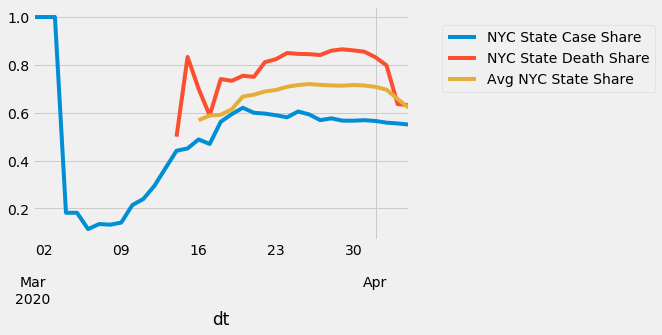

In [6]:
ax = df_reporting_fmt['NYC_case_share'].dropna().plot(label='NYC State Case Share', legend=True)
_ = df_reporting_fmt['NYC_death_share'].dropna().plot(label='NYC State Death Share', legend=True, ax=ax)
_ = df_reporting_fmt['NYC_mean_share'].dropna().rolling(3).mean().plot(
label='Avg NYC State Share', legend=True, ax=ax)
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)


## Bring in Movement Data from City Mapper

In [7]:
## THIS SECTION STOPPED WORKING ON APRIL 4 ##

In [8]:
# raw_entropy = pd.read_html('https://citymapper.com/cmi/nyc')

# l_cardinals = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th', '29th', '30th', '31st']

# df_entropy = raw_entropy[0].astype(str).applymap(lambda x: 
#                      x[3:] if x[:3] in l_cardinals else (x[4:] if x[:4] in l_cardinals else x))
# df_entropy = df_entropy.replace('%','', regex=True)
# df_entropy = df_entropy.apply(pd.to_numeric, errors='coerce')/100.
# df_entropy = df_entropy.dropna(how='all').reset_index()
# df_entropy = df_entropy.drop(columns='index')
# df_entropy.columns = list(range(2,9))
# df_entropy = df_entropy.stack().reset_index()
# df_entropy['day_o_month'] = (df_entropy['level_0'] * 7 + df_entropy['level_1']).astype(str)
# df_entropy['dt'] = pd.to_datetime('2020-03-'+df_entropy['day_o_month'])
# df_entropy = df_entropy[[0,'dt']]
# df_entropy = df_entropy.rename(columns={0:'entropy_pct'}).set_index('dt').sort_index()
# df_entropy.head()

## Bring in State Data

In [9]:
df_st_testing_raw = pd.read_csv(
    'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv')
df_st_testing = df_st_testing_raw
df_st_testing['dt'] = pd.to_datetime(df_st_testing['date'], format="%Y%m%d")
print("State Testing Data Last Observation: ", df_st_testing.date.max())
df_st_testing = df_st_testing.rename(columns={'state':'code'})
df_st_testing = df_st_testing.set_index(['code','dt']).sort_index()

df_st_testing.loc[['NY'],:] = (
    df_st_testing.loc[['NY'],:].shift(-1))
df_st_testing.loc[['NY']].tail()

State Testing Data Last Observation:  20200404


date  positive  negative  pending  \
code dt                                                    
NY   2020-03-31  20200401.0   83712.0  137168.0      NaN   
     2020-04-01  20200402.0   92381.0  146584.0      NaN   
     2020-04-02  20200403.0  102863.0  157657.0      NaN   
     2020-04-03  20200404.0  113704.0  169917.0      NaN   
     2020-04-04         NaN       NaN       NaN      NaN   

                 hospitalizedCurrently  hospitalizedCumulative  \
code dt                                                          
NY   2020-03-31                12226.0                 18368.0   
     2020-04-01                13383.0                 20817.0   
     2020-04-02                14810.0                 23696.0   
     2020-04-03                15905.0                 26383.0   
     2020-04-04                    NaN                     NaN   

                 inIcuCurrently  inIcuCumulative  onVentilatorCurrently  \
code dt                                                                   
NY   2020-03-31          3022.0           3022.0                    NaN   
     2020-04-01          3396.0              NaN                    NaN   
     2020-04-02          3731.0              NaN                    NaN   
     2020-04-03          4126.0              NaN                    NaN   
     2020-04-04             NaN              NaN                    NaN   

                 onVentilatorCumulative  ...  hospitalized     total  \
code dt                                  ...                           
NY   2020-03-31                     NaN  ...       18368.0  220880.0   
     2020-04-01                     NaN  ...       20817.0  238965.0   
     2020-04-02                     NaN  ...       23696.0  260520.0   
     2020-04-03                     NaN  ...       26383.0  283621.0   
     2020-04-04                     NaN  ...           NaN       NaN   

                totalTestResults    posNeg  fips  deathIncrease  \
code dt                                                           
NY   2020-03-31         220880.0  220880.0  36.0          391.0   
     2020-04-01         238965.0  238965.0  36.0          432.0   
     2020-04-02         260520.0  260520.0  36.0          562.0   
     2020-04-03         283621.0  283621.0  36.0          630.0   
     2020-04-04              NaN       NaN   NaN            NaN   

                 hospitalizedIncrease  negativeIncrease  positiveIncrease  \
code dt                                                                     
NY   2020-03-31                2464.0            7777.0            7917.0   
     2020-04-01                2449.0            9416.0            8669.0   
     2020-04-02                2879.0           11073.0           10482.0   
     2020-04-03                2687.0           12260.0           10841.0   
     2020-04-04                   NaN               NaN               NaN   

                 totalTestResultsIncrease  
code dt                                    
NY   2020-03-31                   15694.0  
     2020-04-01                   18085.0  
     2020-04-02                   21555.0  
     2020-04-03                   23101.0  
     2020-04-04                       NaN  

[5 rows x 24 columns]

In [10]:
fillin_NYS_hosp = pd.Series(
    [240,379,656,830,1239,1337,2049,2520,3069.,4079.], index=
         pd.date_range('2020-03-15','2020-03-24'))

df_st_testing = df_st_testing.unstack(0)
df_st_testing.loc[:,[('hospitalizedCurrently','NY')]
                            ] = df_st_testing.loc[
    :,('hospitalizedCurrently','NY')].fillna(fillin_NYS_hosp)
df_st_testing = df_st_testing.stack().swaplevel().sort_index()


## Bring in NYC DOH Data

In [11]:
df_nycdoh_raw = pd.read_csv('https://github.com/nychealth/coronavirus-data/raw/master/case-hosp-death.csv')
df_nycdoh = df_nycdoh_raw
df_nycdoh['dt'] = pd.to_datetime(df_nycdoh['DATE_OF_INTEREST'])
df_nycdoh = df_nycdoh.set_index('dt')
df_nycdoh.tail()

,DATE_OF_INTEREST,NEW_COVID_CASE_COUNT,HOSPITALIZED_CASE_COUNT,DEATH_COUNT
dt,,,,
2020-04-01,4/1/20,3571,905.0,217.0
2020-04-02,4/2/20,3905,956.0,213.0
2020-04-03,4/3/20,3250,786.0,209.0
2020-04-04,4/4/20,1091,111.0,137.0
2020-04-05,4/5/20,82,NaN,34.0


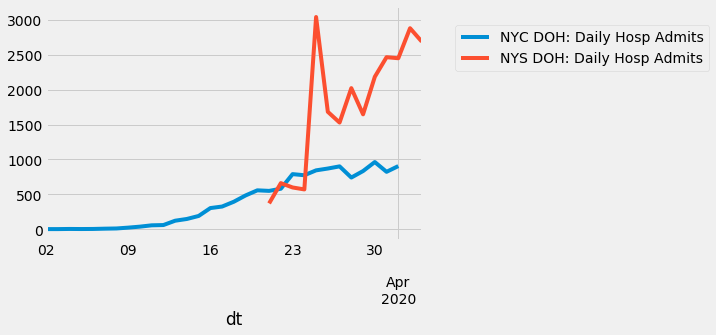

In [12]:
#Note: While all of the NYC DOH data is subject to change, the most recent three days are extremely
# volatile. So, we exclude those days.
ax = df_nycdoh.HOSPITALIZED_CASE_COUNT.iloc[:-4].plot(label='NYC DOH: Daily Hosp Admits')
df_st_testing.loc['NY']['hospitalizedCumulative'].diff().plot(ax=ax, label='NYS DOH: Daily Hosp Admits')
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)

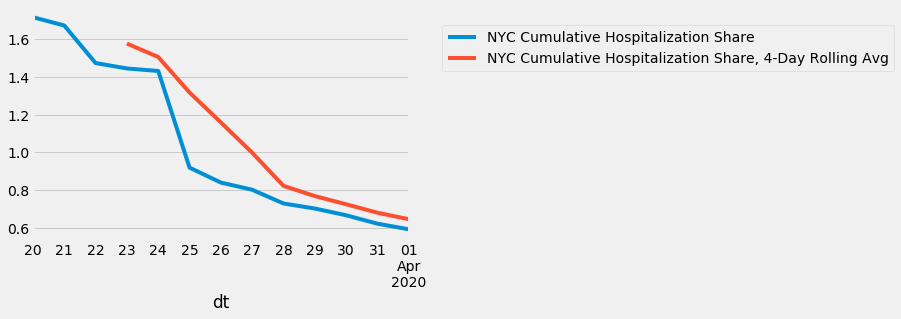

In [13]:
df_reporting_fmt['NYC_cumulhosp_share'] = (df_nycdoh['HOSPITALIZED_CASE_COUNT'].cumsum().iloc[:-4]/df_st_testing.loc['NY']['hospitalizedCumulative']
)
ax = df_reporting_fmt['NYC_cumulhosp_share'].dropna().plot(label='NYC Cumulative Hospitalization Share', legend=True)
df_reporting_fmt['NYC_cumulhosp_share'].rolling(4).mean().dropna().plot(
    label='NYC Cumulative Hospitalization Share, 4-Day Rolling Avg', legend=True, ax=ax)
_ = plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)


## Estimate NYC Simultaneous Hospitalization Data

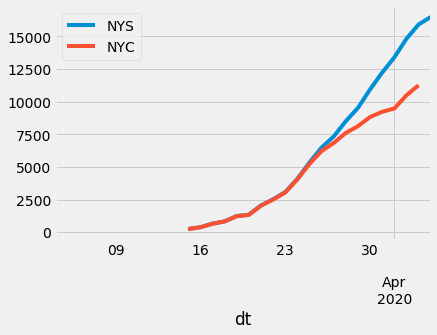

In [68]:
df_hosps = pd.DataFrame(df_st_testing.loc['NY',('hospitalizedCurrently')])
df_hosps.columns = ['NYS']
df_hosps.loc[pd.Timestamp('2020-04-04'),'NYS'] = 16479
df_hosps['NYC'] = df_reporting_fmt['NYC_cumulhosp_share'
                                  ].fillna(method='bfill').clip(upper=0.99).rolling(7).mean().fillna(method='ffill')\
.mul(df_st_testing.loc['NY',('hospitalizedCurrently')])
df_hosps.plot()

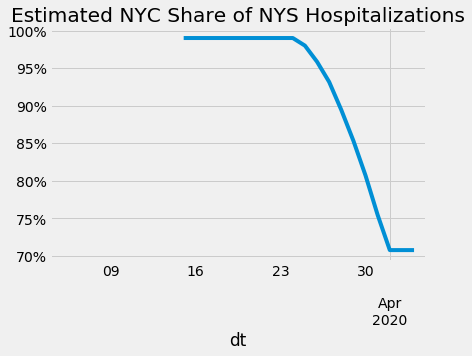

In [69]:
ax = df_hosps['NYC'].div(df_hosps.NYS).plot(title='Estimated NYC Share of NYS Hospitalizations')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))


# Model Functions

In [70]:
def seir_model(suspop_0, exposed_0, infectious_0, recovered_0, deaths_0, last_obs_dt, 
               r0, d_incub, d_infect, 
               t):

    suspop, exposed, infectious, resolved = [suspop_0], [exposed_0], [infectious_0], [recovered_0 + deaths_0]
    alpha = 1 / d_incub
    beta = r0 / d_infect
    gamma = 1 / d_infect
    totpop = suspop_0 + exposed_0 + infectious_0 + recovered_0 + deaths_0
    
    for t_ in t[:-1]:
        dS_dt = -1 * min(beta * suspop[-1] * infectious[-1] / totpop, suspop[-1]) 
        dE_dt = (dS_dt * -1) - (alpha * exposed[-1])
        dI_dt = (alpha * exposed[-1]) - (gamma * infectious[-1])
        dR_dt = (gamma * infectious[-1])
        
        next_suspop = suspop[-1] + dS_dt
        next_exposed = exposed[-1] + dE_dt
        next_infectious = infectious[-1] + dI_dt
        next_resolved = resolved[-1] + dR_dt
        
        suspop.append(next_suspop)
        exposed.append(next_exposed)
        infectious.append(next_infectious)
        resolved.append(next_resolved)
        
    df_out = pd.DataFrame(np.stack([suspop, exposed, infectious, resolved]).T,
                         index = pd.date_range(last_obs_dt, 
                                               last_obs_dt + pd.Timedelta(days=t.shape[0]-1)),
                         columns = ['suspop', 'exposed', 'infectious', 'resolved'])
        
    return df_out


In [71]:
def param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
                    hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0):
    
    param_dict = {'d_incub':(d_incub,'{:.1f}'), 
                  'd_infect':(d_infect,'{:.1f}'), 
                  'd_to_hosp':(d_to_hosp,'{:.1f}'), 
                  'd_in_hosp':(d_in_hosp,'{:.1f}'), 
                  'd_til_death':(d_til_death,'{:.1f}'),
                  'hosp_rt':(hosp_rt,'{:.2%}'), 
                  'icu_rt':(icu_rt,'{:.2%}'), 
                  'vent_rt':(vent_rt,'{:.2%}'), 
                  'mort_rt':(mort_rt,'{:.2%}'), 
                  'basic_r0':(basic_r0,'{:.1f}')}
    param_fmtd_dict = {}

    for param_name, param_tup in param_dict.items():
        param_val, param_fmt = param_tup
        if type(param_val) == tuple:
            param_fmtd_dict[param_name] = (param_fmt+' - '+param_fmt).format(*param_val)
        else:
            param_fmtd_dict[param_name] = param_fmt.format(param_val)
        

    param_str = '\n'.join(('Parameters Used',
                           r'$D_{{incubation}}: {}$'.format(param_fmtd_dict['d_incub'], ),
                           r'$D_{{infectious}}: {}$'.format(param_fmtd_dict['d_infect'], ),
                           r'$D_{{to hospital}}: {}$'.format(param_fmtd_dict['d_to_hosp'], ),
                           r'$D_{{in hospital}}: {}$'.format(param_fmtd_dict['d_in_hosp'], ),
                           r'$D_{{til death}}: {}$'.format(param_fmtd_dict['d_til_death'], ),
                           r'$Rate_{{Hospitalization}}: {}$'.format(param_fmtd_dict['hosp_rt'], )+'%',
                           r'$Rate_{{ICU}}: {}$'.format(param_fmtd_dict['icu_rt'], )+'%',
                           r'$Rate_{{Ventilator}}: {}$'.format(param_fmtd_dict['vent_rt'], )+'%',
                           r'$Rate_{{Mortality}}: {}$'.format(param_fmtd_dict['mort_rt'], )+'%',
                           r'$Basic R_{{0}}: {}$'.format(param_fmtd_dict['basic_r0'], )
                          ))
    return param_str

In [72]:
def ch_exposed_infectious(df_agg, r_t, region_name, param_str, chart_title=""):
    plt.style.use('fivethirtyeight')
    df_chart = df_agg[['exposed','infectious']]
#     df_chart = df_chart.iloc[8:]

    ax = df_chart.plot.area(figsize=[14,8], title=chart_title, legend=True,
                           color=['#e5ae38','#fc4f30'])
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.legend(['Exposed Population','Infectious Population'],
               loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax2 = ax.twinx()
    r_t.plot(ax=ax2, color='black', linewidth=2, linestyle='--', 
                       label='Reproduction Factor (r0) - Right Axis', legend=True)
    plt.legend(loc="lower right")
    ax.set_ylim([0, ax.axes.get_yticks().max()])
    ax.set_yticks(np.linspace(0,ax.axes.get_yticks().max(),5))
    ax2.set_ylim([0, ax2.axes.get_yticks().max()])
    ax2.set_yticks(np.linspace(0,ax2.axes.get_yticks().max(),5))
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()

In [73]:
def ch_cumul_infections(df_agg, df_reporting_fmt, region_name, param_str, chart_title=""):
    plt.style.use('fivethirtyeight')
    df_chart = df_agg[['exposed', 'infectious', 'recovered', 'hospitalized', 'deaths']].sum(axis=1)
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title=chart_title, legend=True, 
                       label='Forecast Cumulative Infections')
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    if region_name in df_reporting_fmt['cases'].columns:
        df_reporting_fmt['cases'][region_name].loc['2020-03-01':].plot(
            ax=ax, linestyle=':', legend=True, color=['#008fd5'],
        label='Reported Cumulative Infections')
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [74]:
def ch_hosp(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    df_chart = df_agg[['hospitalized','vent','icu','deaths']]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title=chart_title)
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    if region_name in df_hosps.columns:
        df_hosps[region_name].plot(ax=ax, linestyle=':', legend=True,
                                   label='Observed {} Hospitalizations'.format(region_name))
    if region_name in df_reporting_fmt['deaths'].columns:
        df_reporting_fmt['deaths'][region_name].loc[
            df_hosps.index[0]:].plot(ax=ax, linestyle='-.', legend=True,
                                   label='deaths {} Cumulative Cases'.format(region_name))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()

In [75]:
def ch_population_share(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    df_chart = df_agg[['susceptible','deaths','exposed','hospitalized','infectious','recovered']]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot.area(
        figsize=[14,8], title=chart_title)
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [76]:
def ch_doubling_rt(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title=""):
    ## DOUBLING RATE CHART
    df_chart = np.log(2)/df_agg[['hospitalized','deaths']].pct_change()
#     df_chart = df_chart.loc[hosp_obs_dt:]
    df_chart = df_chart.iloc[8:]
    
    ax = df_chart.plot(figsize=[14,8], title='Forecast Doubling Rate: '+chart_title,
                      color=['#008fd5','#e5ae38'])
    if region_name in df_hosps.columns:
        hosp_dr = np.log(2)/df_hosps[region_name].pct_change().rolling(3).mean()
        hosp_dr.plot(ax=ax, linestyle=':', legend=True, color=['#008fd5'],
                     label='Observed {} Hospitalizations'.format(region_name))
    if region_name in df_reporting_fmt['deaths'].columns:
        deaths_dr = np.log(2)/df_reporting_fmt['deaths'][region_name].pct_change().rolling(3)\
            .mean().loc[hosp_dr.index[0]:]
        deaths_dr.plot(ax=ax, linestyle='-.', legend=True, color=['#e5ae38'],
                       label='Deaths {} Cumulative Cases'.format(region_name))
    plt.yscale('log')
    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))
    plt.legend(loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)
    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()
    

In [77]:
def daily_cohort_model(cohort_strt, d_to_fore, 
                       d_incub, d_infect,
                       mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                       icu_rt, d_in_icu, vent_rt,
                       E_0, I_0=0., H_0=0., ICU_0=0., R_0=0., D_0=0.
                      ):
    
    t = np.linspace(0, int(d_to_fore)-1, int(d_to_fore))

    E = [E_0]
    I = [I_0]
    H = [H_0]
    ICU = [ICU_0]
    R = [R_0]
    D = [D_0]
    
    for t_ in t[:-1]:
        
        #### PROBABILITY DISTRIBUTIONS FOR FLOWS ####
        prob_dI_t = gamma.pdf(t_,d_incub)

        prob_mild_dR_t = (1 - hosp_rt) * gamma.pdf(t_, d_infect+d_incub)

        prob_H_inflow_t = hosp_rt * gamma.pdf(t_, d_to_hosp+d_incub)


        prob_sev_dR_t = (hosp_rt - mort_rt) * gamma.pdf(t_, (d_in_hosp+d_to_hosp)/2, scale=2, 
                                            loc=d_incub)

        prob_dD_t = mort_rt * gamma.pdf(t_, d_til_death/2, scale=2, loc=d_incub)
        #############################################
        

        ############## FLOW ACCOUNTING ##############
        # Change in Exposed Population
        dE = -1 * min(prob_dI_t * E_0, E[-1])
        
        # Hospital Outflows, limited to be no more than hospital capacity
        d_hosp_outflow = -1 * min((prob_sev_dR_t * (E_0+I_0) 
                                   + prob_sev_dR_t * H_0 / hosp_rt)
                                  + (prob_dD_t * (E_0+I_0)
                                   + prob_dD_t * H_0 / hosp_rt), 
                                  H[-1])
        
        if (prob_sev_dR_t + prob_dD_t) > 0:
            # Severe Recoveries - Component of Hospital Outflows
            d_sevR = (-1 * prob_sev_dR_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)

            # Deaths - Component of Hospital Outflows
            dD = (-1 * prob_dD_t * d_hosp_outflow) / (prob_sev_dR_t + prob_dD_t)
        else:
            # Severe Recoveries - Component of Hospital Outflows
            d_sevR = 0.
            # Deaths - Component of Hospital Outflows
            dD = 0.
        
        # New Hospital Admittances
        d_hosp_admits = ((prob_H_inflow_t * E_0)
                         + (hosp_rt * I_0 * ((1-1/d_to_hosp)**(t_-1) - (1-1/d_to_hosp)**t_)))
        
        # Infectious Inflows
        dI_inflow = -1 * dE
        
        # Mild Recoveries
        d_mildR = min(prob_mild_dR_t * (E_0+I_0), I[-1] + dI_inflow - d_hosp_admits)
        
        # Change in Recovered Population
        dR = d_mildR + d_sevR
        
        # Change in Hospitalized Population
        dH = d_hosp_admits + d_hosp_outflow
        
        # Infectious Outflows
        dI_outflow = d_mildR + d_hosp_admits
        
        # Net change in Infectious Population
        dI = dI_inflow - dI_outflow
        
        if round(dI_inflow - dI_outflow) < round(-1 * I[-1]):
            print('dI_inflow',dI_inflow)
            print('dI_outflow',dI_outflow)
            print('round(dI_inflow - dI_outflow)',round(dI_inflow - dI_outflow))
            print('I[-1]',I[-1])
            raise Exception(cohort_strt, 'Daily Cohort Infectious Net Outflows are greater than Infectious Population') 
        #############################################

        E.append(E[-1] + dE)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)
        H.append(H[-1] + dH)
        D.append(D[-1] + dD)
    df_out = pd.DataFrame(np.stack([E, I, R, H, D]).T, 
                          columns = ['exposed', 'infectious', 'recovered', 'hospitalized', 'deaths'],
                          index = pd.date_range(cohort_strt, 
                                                cohort_strt + pd.Timedelta(days=d_to_fore-1)))
    df_out['icu'] = df_out['hospitalized'].mul(icu_rt)
    df_out['vent'] = df_out['hospitalized'].mul(icu_rt*vent_rt)
    df_out.index = pd.DatetimeIndex(df_out.index).normalize()
    df_out.index.name = 'dt'
    df_out.columns.name = 'metric'
    
    return df_out


In [90]:
def seir_model_cohort(suspop_0, exposed_0, infectious_0, recovered_0, deaths_0, hosp_obs_dt, 
                      r_t, d_incub, d_infect, d_to_forecast, 
                      mort_rt, d_in_hosp, hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                      icu_rt, d_in_icu, vent_rt
                     ):

    d_to_forecast = int(d_to_forecast)
    suspop = [suspop_0]
    next_infectious  = infectious_0
    _gamma = 1 / d_infect
    totpop = suspop_0 + exposed_0 + infectious_0 + recovered_0 + deaths_0
    
    t = np.linspace(0, d_to_forecast+int(d_incub+d_to_hosp), 
                    d_to_forecast+int(d_incub+d_to_hosp)+1)
    
    df_all_cohorts = pd.DataFrame()
    df_all_cohorts.columns.name = 'cohort_dt'
    last_r = r_t[0]
    
    for t_ in t[:-1]:
        this_r = r_t[int(t_)]
        
        beta = this_r * _gamma
        cohort_strt = hosp_obs_dt + pd.Timedelta(days=t_-int(d_incub+d_to_hosp))
        d_to_fore = t[-1] - t_ + 1
        
        if this_r != last_r:
            last_r = this_r

        if t_ == 0:
            dS = 0
            
            df_daily_cohort = daily_cohort_model(
                cohort_strt, d_to_fore, 
                d_incub, d_infect, mort_rt, d_in_hosp, 
                hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                icu_rt, d_in_icu, vent_rt,
                E_0=exposed_0, I_0=infectious_0, H_0=0., 
                ICU_0=0., 
                R_0=recovered_0, D_0=deaths_0
            )

            df_all_cohorts[cohort_strt] = df_daily_cohort.stack()
            
            df_daily_cohort_scalar = daily_cohort_model(
                cohort_strt, d_to_fore, 
                d_incub, d_infect, mort_rt, d_in_hosp, 
                hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                icu_rt, d_in_icu, vent_rt,
                1e6
            ).reset_index(drop=True)
            
        else:
            dS = -1 * min(beta * suspop[-1] * next_infectious / totpop, suspop[-1]) 
            
            df_daily_cohort = dS * -1 * df_daily_cohort_scalar.iloc[:int(d_to_fore)] / 1e6
            
            df_daily_cohort.index = pd.date_range(cohort_strt, 
                                                  cohort_strt + pd.Timedelta(days=d_to_fore - 1))
            df_all_cohorts[cohort_strt] = df_daily_cohort.stack()
    
        d_cohort_totpop_std = round(df_daily_cohort[
            ['exposed','deaths','hospitalized','infectious','recovered']
        ].dropna().sum(axis=1).std(),3)
        
        if d_cohort_totpop_std != 0.0:
            print(cohort_strt, d_cohort_totpop_std)
            raise Exception('Daily Cohort total population varies significantly') 
        
        df_agg = df_all_cohorts.sum(axis=1).unstack()
        df_agg.index = pd.DatetimeIndex(df_agg.index).normalize()
        next_infectious = df_agg.loc[cohort_strt,'infectious']
        next_suspop = suspop[-1] + dS
        suspop.append(next_suspop)
        
        totpopchk = df_agg.loc[cohort_strt, ['exposed','infectious','recovered','hospitalized','deaths']].sum()
        
        if (round(totpopchk + suspop[-1]) != round(totpop)):
            display(df_all_cohorts.sum(axis=1).unstack())
            print(cohort_strt)
            print('totpop: ', round(totpop))
            print(suspop_0, exposed_0, infectious_0, recovered_0, deaths_0)
            print('dS ', dS)
            print('sum of df_agg', totpopchk)
            print('suspop[-1]', suspop[-1])
            print('sum of both', round(totpopchk+suspop[-1]))
            raise Exception('Agg total population varies significantly') 

    ## Adjust initiailized cohort hospitalizations to observation. ##
#     hosp_acts_rat = curr_hosp/df_all_cohorts.sum(axis=1).unstack(1)['hospitalized'].loc[hosp_obs_dt]
#     df_new_hosp = df_all_cohorts.loc[:,:hosp_obs_dt].unstack(1).swaplevel(axis=1)[
#         ['hospitalized','icu','vent']]*hosp_acts_rat
#     df_new_hosp = df_new_hosp.stack(0)
#     df_all_cohorts.update(df_new_hosp)
    #################################################################
    
    df_agg = df_all_cohorts.sum(axis=1).unstack()
    df_agg.index = pd.DatetimeIndex(df_agg.index).normalize()

    s_suspop = pd.Series(suspop, index = pd.date_range(
        hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)+1), 
        hosp_obs_dt + pd.Timedelta(days=d_to_forecast-1)))
        
    df_agg['susceptible'] = pd.Series(s_suspop)
    
    return df_agg.dropna(), df_all_cohorts

In [91]:
def run_cohort_model(d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths,
                     hosp_obs_dt, basic_r0, r_dates,
                     d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt,
                     d_til_death, d_in_hosp_mild, d_to_hosp,
                     icu_rt, d_in_icu, vent_rt,
                     scenario_name, region_name, df_hosps, df_reporting_fmt
                    ):
    
    curr_exposed = curr_hosp/hosp_rt*exposed_pct
    curr_infectious = curr_hosp/hosp_rt*(1-exposed_pct)
    r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
                                                hosp_obs_dt + pd.Timedelta(days=d_to_forecast)))
    pa_s = pd.DataFrame(r_dates)
    pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
    pa_s.index = pd.to_datetime(pa_s.index).normalize()
    r_t.index = pd.DatetimeIndex(r_t.index).normalize()
    r_t = r_t.fillna(pa_s)
    if pd.isnull(r_t.iloc[0]):
        r_t.iloc[0] = basic_r0
    r_t = r_t.fillna(method='ffill')
    l_r_t = r_t.to_list()
    
    chart_title = "{0}: {1} Scenario - Basic R0: {2:.2f}\nForecast Using Hospitalization Data through {3}".format(
        region_name, scenario_name, basic_r0, hosp_obs_dt.strftime("%d %b"))

    df_agg, df_all_cohorts = seir_model_cohort(
        curr_suspop, curr_exposed, curr_infectious, curr_recovered, curr_deaths, hosp_obs_dt,
        l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
        hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
        icu_rt, d_in_icu, vent_rt
    ) 
    
    df_agg['r_t'] = r_t
    
    param_str = param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
                    hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0)
    ch_exposed_infectious(df_agg, r_t, region_name, param_str, chart_title)
    
    ch_hosp(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)
    
    ch_cumul_infections(df_agg, df_reporting_fmt, region_name, param_str, chart_title)
    
    ch_population_share(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)    

    ch_doubling_rt(df_agg, df_hosps, df_reporting_fmt, region_name, param_str, chart_title)
    
    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))
    
    return df_agg, df_all_cohorts


In [92]:
def regr_repro(s_hosps, obs_dt, lookback, d_infect):
    y = s_hosps.loc[:obs_dt].iloc[-lookback:].dropna().values
    y = np.log(y)
    
    available_lookback = y.shape[0]
    X = np.linspace(0, available_lookback-1, available_lookback).reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True).fit(X, y)

    _lambda = reg.coef_[0]
    _gamma = 1 / d_infect
    _beta = _lambda + _gamma
    _r0 = _beta / _gamma
    return _lambda, _gamma, _beta, _r0

def est_r_t(df_hosps, region_name, lookback, d_infect, d_incub, d_to_hosp):
    r_t = pd.Series(dtype='float64')
    for dt in df_hosps[region_name].dropna().iloc[2:].index:
        _,_,_,r_t.loc[dt] = regr_repro(df_hosps[region_name], dt, lookback, d_infect)
    r_t.index = (r_t.index - pd.Timedelta(days=d_incub+d_to_hosp)).normalize()
    return r_t



# Model Parameters

In [97]:
############# MODEL PARAMETERS #################
# Total Population
total_pop = 19.6e6 #19.6e6 #8e6 

# Name of Region
region_name = "NYS"

hosp_obs_dt = pd.Timestamp('2020-03-30')#pd.Timestamp('2020-03-25')

# Current Hospitalizations
curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

# Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
exposed_pct = .5 #.2

# Total # of cases currently recovered/immune
curr_recovered = 2000.

# Number of days to forecast
d_to_forecast = 90

# Days from exposure until symptoms (i.e. incubation period)
d_incub=5.1 #4

# Days after incubation period when infectious
d_infect=5.

# Mortality Rate
mort_rt=.01

# Average number of days in hospital for a hospitalized case
d_in_hosp=14.

# Hospitalization Rate of all infected people
hosp_rt=.07

# Days from end of incubation period until death for patients who die
d_til_death=12.

# Days from incubation period til arrival in hospital for all hospitalizations
d_to_hosp=9. #11. #3. #7.

# ICU rate as a proportion of all hospitalizations.
icu_rt = 13./41. #Lancet Study Estimate
 
# Ventilator rate as a proportion of all hospitalizations
vent_rt = .7

# [Currently not functional] Days in hospital for mild hospitalizations
d_in_hosp_mild= 11. #NEJM Study Estimate

# [Currently not functional] Days in hospital for ICU hospitalizations
d_in_icu = 13. #NEJM Study Estimate

# 8 Days Before Hospitalization Data, 
# last_obs_dt = (hosp_obs_dt - pd.Timedelta(days=((d_incub+d_to_hosp)*1.))).round(freq='d')
# print('implied last obs dt:', last_obs_dt)

# Total # of deaths
curr_deaths = df_reporting_fmt['deaths'][region_name].loc[hosp_obs_dt]

# Susceptible Population
curr_suspop = total_pop - curr_hosp/hosp_rt - curr_recovered - curr_deaths
print('curr hosp obs dt: ', hosp_obs_dt)
print('curr_hosp: ',curr_hosp)
print('curr_deaths: ',curr_deaths)

curr hosp obs dt:  2020-03-30 00:00:00
curr_hosp:  10929.0
curr_deaths:  1062.0


# Scenarios

In [98]:
df_scenarios = pd.DataFrame()

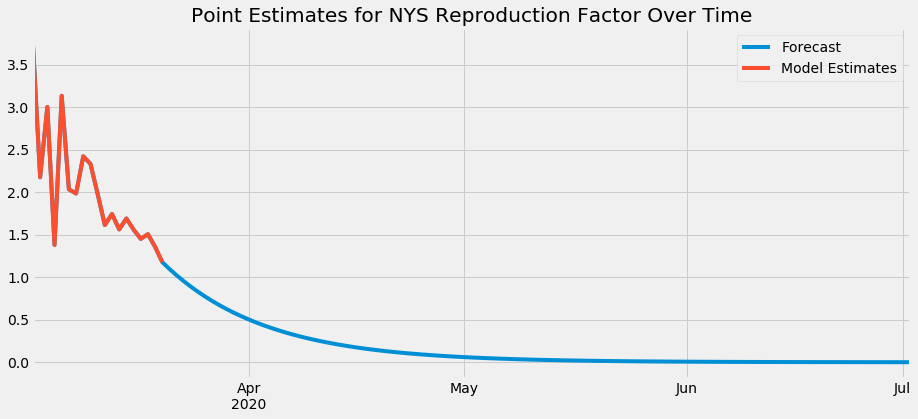

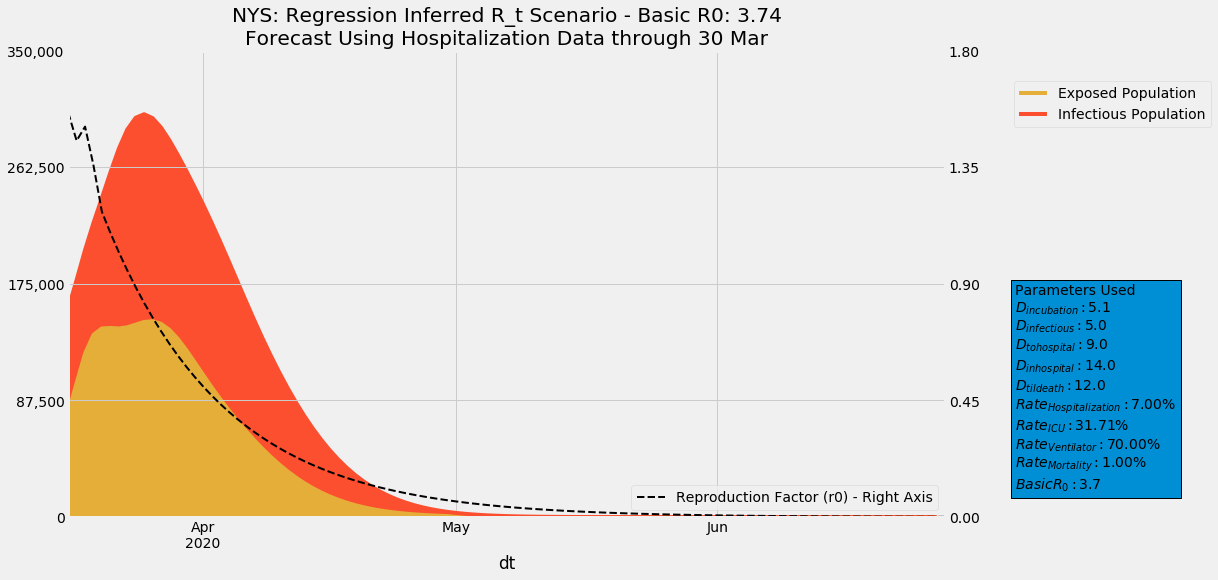

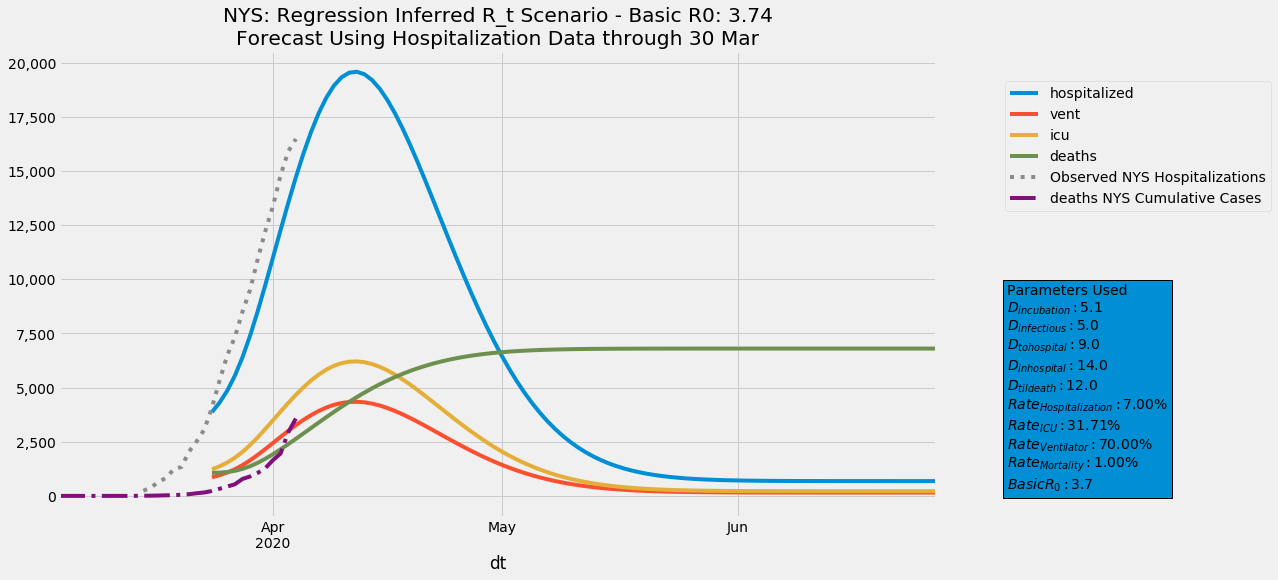

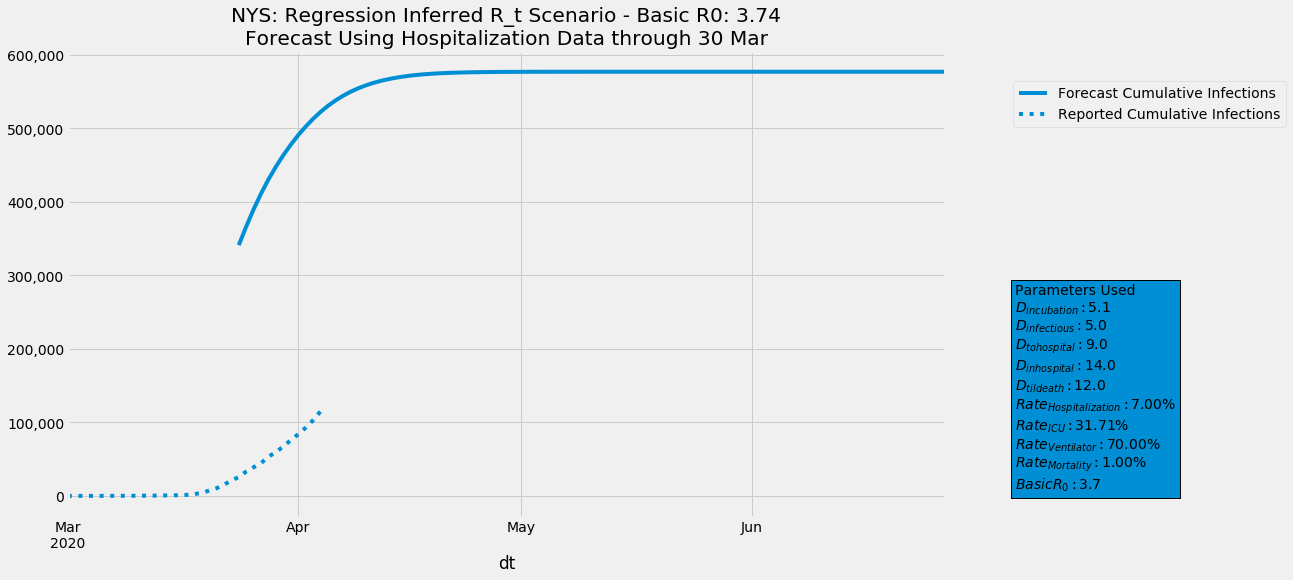

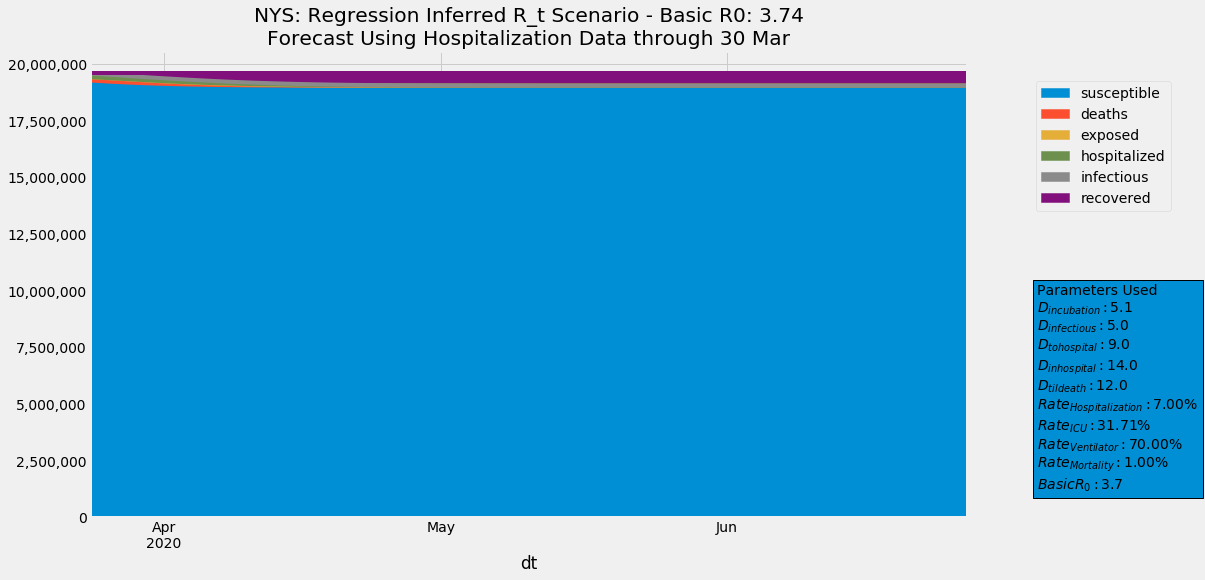

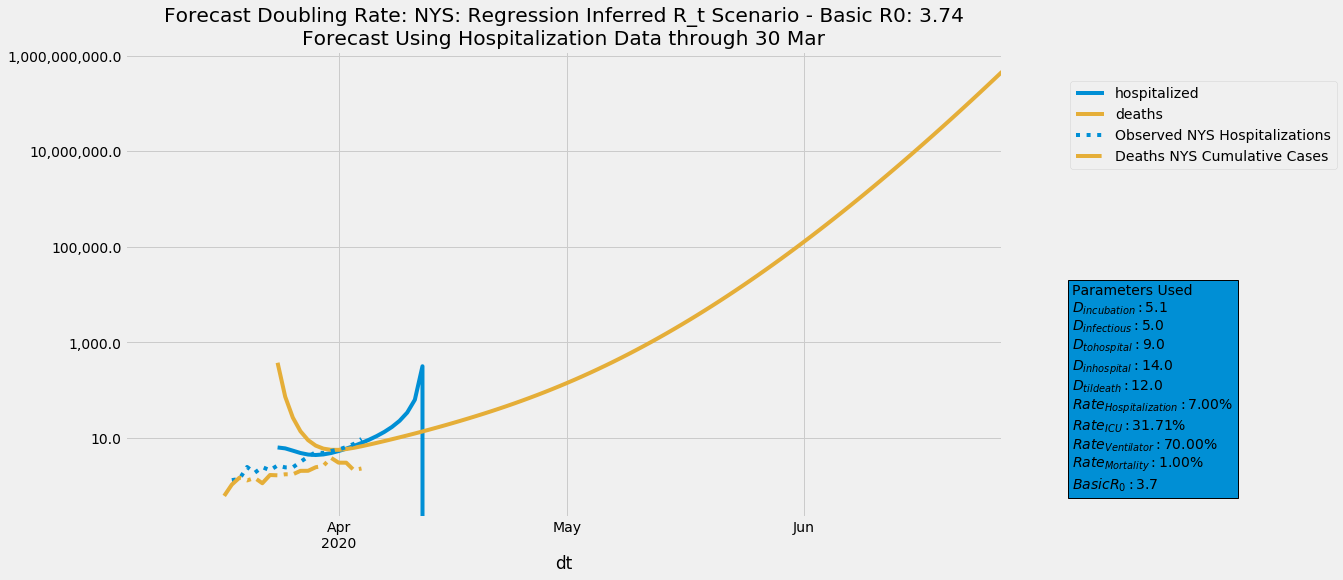

Peak Hospitalization Date:  12 Apr, 2020
Peak Hospitalization #: 19584
Peak ICU #: 6210
Peak Ventilator #: 4347


In [102]:
r_t = est_r_t(df_hosps, region_name, 2, d_infect, d_incub, d_to_hosp)
basic_r0 = r_t.iloc[0]

mul_r_t = pd.Series((1+r_t.pct_change().rolling(5).mean().iloc[-1]), 
                    index=pd.date_range(r_t.index[-1]+pd.Timedelta(days=1),
                                    r_t.index[-1]+pd.Timedelta(days=d_to_forecast+d_incub+d_to_hosp)
                                   )).cumprod()
fore_r_t = mul_r_t.mul(r_t.iloc[-1])
fore_r_t = pd.concat([r_t, fore_r_t])

ax = fore_r_t.plot(label='Forecast', figsize=[14,6], legend=True,
              title='Point Estimates for {} Reproduction Factor Over Time'.format(region_name))
r_t.plot(ax=ax, label='Model Estimates', legend=True)

r_dates = list(pd.DataFrame(fore_r_t).itertuples(index=True))
# Scenario Name
scenario_name = "Regression Inferred R_t"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()

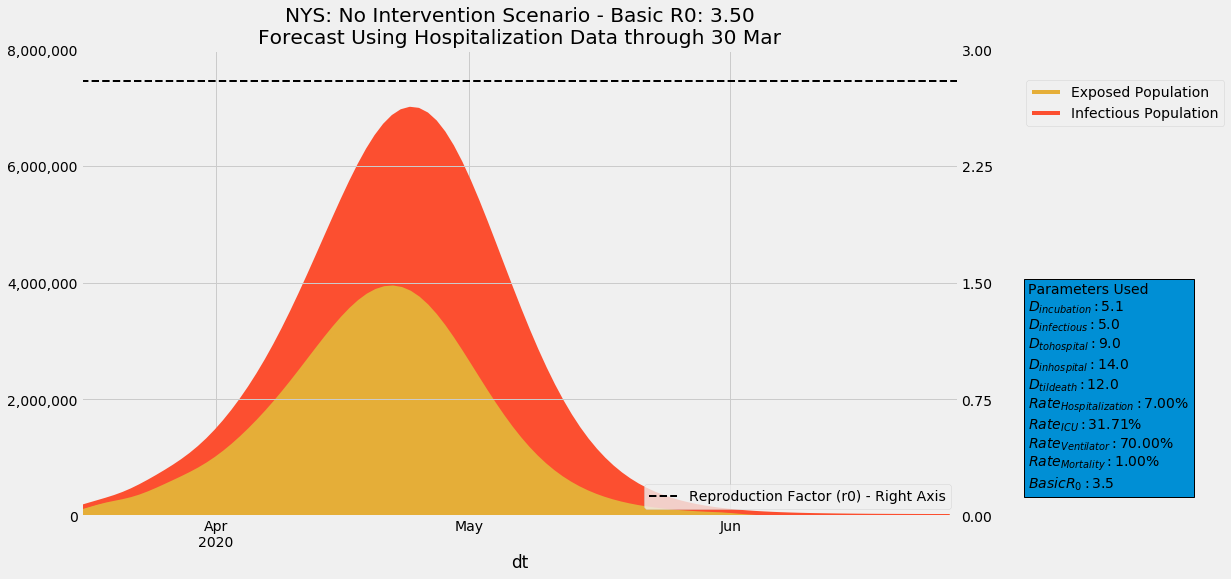

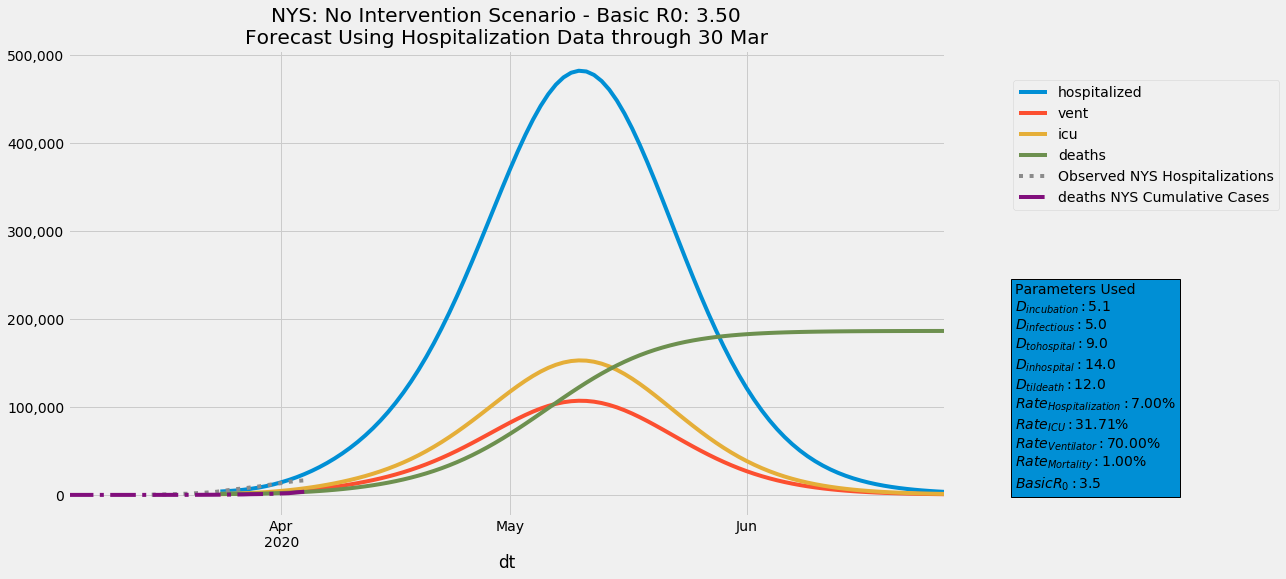

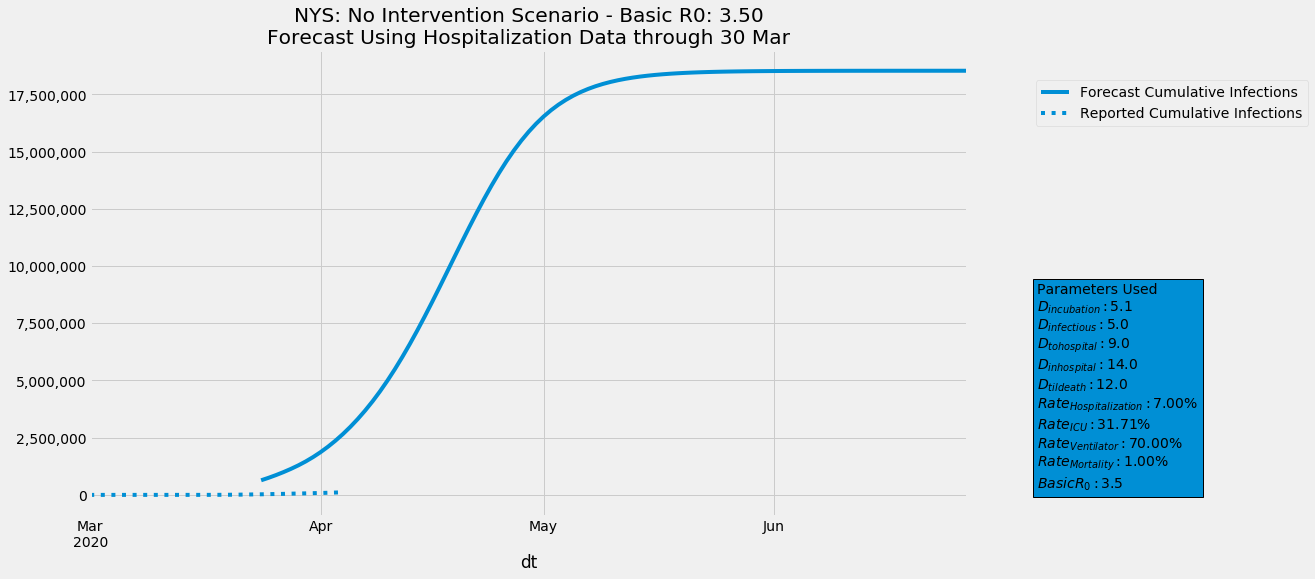

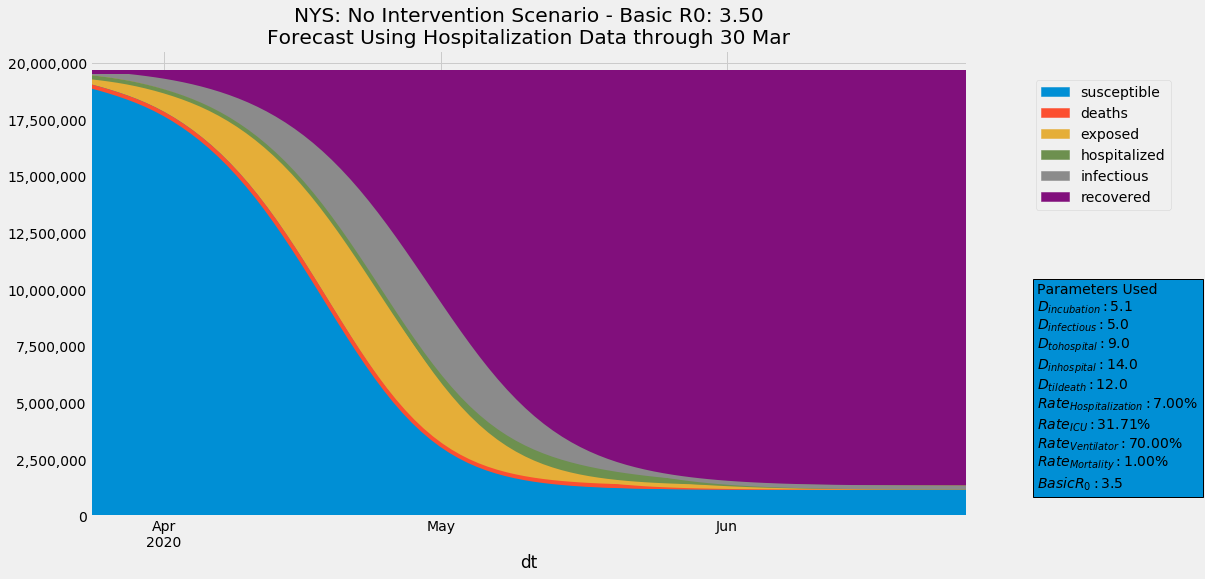

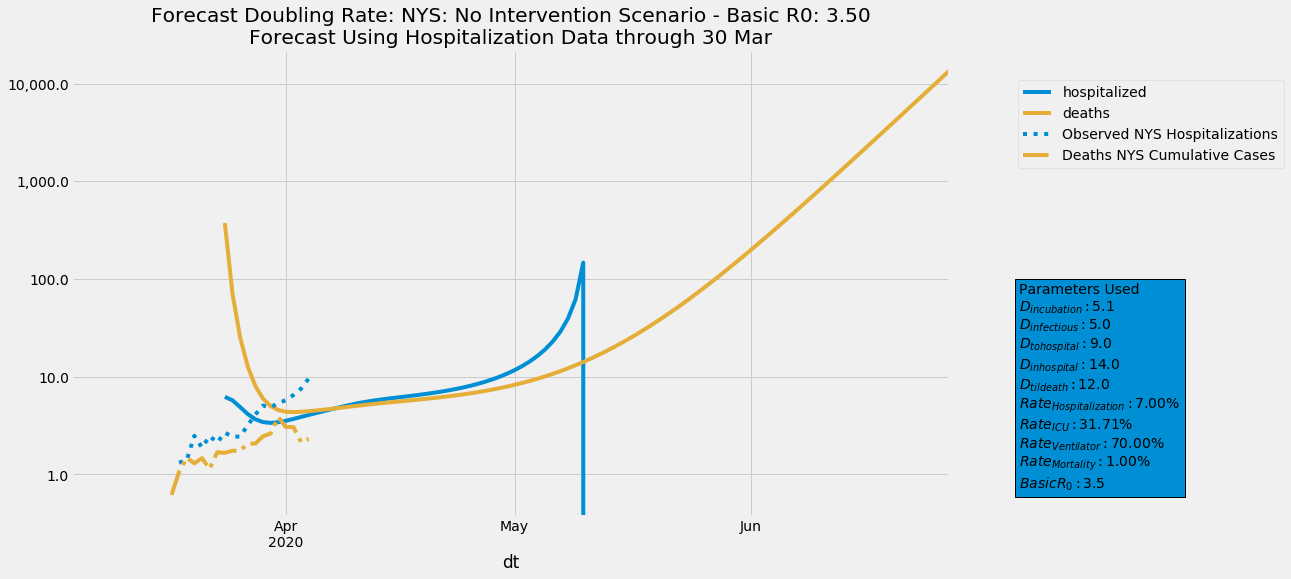

Peak Hospitalization Date:  10 May, 2020
Peak Hospitalization #: 482051
Peak ICU #: 152845
Peak Ventilator #: 106992


In [100]:
# Pre-intervention R0
basic_r0 = 3.5

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.8)]

# Scenario Name
scenario_name = "No Intervention"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


In [ ]:
# # Pre-intervention R0
# basic_r0 = 3.8
# entropy_rep_factor = 0.8
# entropy_lag_factor = int(d_incub+d_infect+2)

# adj_df_entropy = df_entropy.diff().mul(entropy_rep_factor).cumsum().add(
#     df_entropy.iloc[0]).fillna(df_entropy.iloc[0])
# adj_df_entropy = adj_df_entropy.reindex(
#     pd.date_range(adj_df_entropy.index[0],
#                   adj_df_entropy.index[-1]+pd.Timedelta(days=entropy_lag_factor) ) )
# adj_df_entropy = adj_df_entropy.shift(entropy_lag_factor).fillna(method='bfill').clip(lower=0.01)
# ax = adj_df_entropy['entropy_pct'].plot(label='adjusted movement', legend=True)
# df_entropy['entropy_pct'].plot(ax = ax, label='movement', legend=True)
# _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# plt.show()

# # Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# # The second element is the r0 value for that policy action. Policy actions should be separated by
# # a comma.
# r_dates = list(adj_df_entropy.mul(basic_r0).itertuples(index=True))

# # Scenario Name
# scenario_name = "Citymapper Data Adjusted Reproduction Factor"

# df_agg, df_all_cohorts = run_cohort_model(
#     d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
#                  hosp_obs_dt, basic_r0, r_dates, 
#                  d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
#                  d_til_death, d_in_hosp_mild, d_to_hosp, 
#                  icu_rt, d_in_icu, vent_rt,
#                  scenario_name, region_name, df_hosps, df_reporting_fmt)
# df_scenarios[scenario_name] = df_agg.stack()


In [ ]:
# Pre-intervention R0
basic_r0 = 3.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', 0.33), ('2021-05-15',basic_r0*.75)]

# Scenario Name
scenario_name = "Full Wuhan-Style Lockdown"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


In [ ]:
# Pre-intervention R0
basic_r0 = 3.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.7), ('2020-03-24', basic_r0*.15), 
           ('2020-03-31',basic_r0*.1), ('2021-05-15', basic_r0*.6)]

# Scenario Name
scenario_name = "Good"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


In [ ]:
# Pre-intervention R0
basic_r0 = 3.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.4), 
           ('2020-03-31',basic_r0*.3), ('2021-05-15', basic_r0*.7)]

# Scenario Name
scenario_name = "Middle Case"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


In [ ]:
# Pre-intervention R0
basic_r0 = 3.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.95), ('2020-03-24', basic_r0*.5), 
           ('2020-03-31',basic_r0*.4), ('2021-05-15', basic_r0*.8)]

# Scenario Name
scenario_name = "Moderately Bad"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


In [ ]:
# Pre-intervention R0
basic_r0 = 3.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.
r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2021-05-15',basic_r0*.5)]

# Scenario Name
scenario_name = "Alternate Middle Case"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


In [ ]:
# Pre-intervention R0
basic_r0 = 3.8

# Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
# The second element is the r0 value for that policy action. Policy actions should be separated by
# a comma.

r_dates = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2021-05-15',basic_r0*.5*.8),
           ('2020-09-01', basic_r0*.5)]

# Scenario Name
scenario_name = "Alternate Middle Case with Seasonality"

df_agg, df_all_cohorts = run_cohort_model(
    d_to_forecast, curr_suspop, curr_hosp, exposed_pct, curr_recovered, curr_deaths, 
                 hosp_obs_dt, basic_r0, r_dates, 
                 d_incub, d_infect, mort_rt, d_in_hosp, hosp_rt, 
                 d_til_death, d_in_hosp_mild, d_to_hosp, 
                 icu_rt, d_in_icu, vent_rt,
                 scenario_name, region_name, df_hosps, df_reporting_fmt)
df_scenarios[scenario_name] = df_agg.stack()


## Run Scenarios

In [ ]:
chart_col_dict = {'Citymapper Data Adjusted Reproduction Factor':'Activity Data-Based Forecast',
 'Good':'Optimistic Case', 'Middle Case':'Delayed-Effect Middle Case', 'Moderately Bad':'Bad Case',
       'Alternate Middle Case':'Middle Case'}

In [ ]:
scenario_dict = {}

In [ ]:
############# MODEL PARAMETERS #################
# Total Population
total_pop = 8e6 #19.6e6 #8e6 

# Name of Region
region_name = "NYC"

hosp_obs_dt = pd.Timestamp('2020-03-31')#pd.Timestamp('2020-03-25')

# Current Hospitalizations
curr_hosp = df_hosps[region_name].loc[hosp_obs_dt]

# Proportion of Total Infected/Exposed Population that is Exposed (i.e. not yet infectious)
exposed_pct = .5 #.2

# Total # of cases currently recovered/immune
curr_recovered = 2000.

# Number of days to forecast
d_to_forecast = 200 #60

# Days from exposure until symptoms (i.e. incubation period)
d_incub=5.1 #4

# Days after incubation period when infectious
d_infect=5.

# Mortality Rate
mort_rt=.008

# Average number of days in hospital for a hospitalized case
d_in_hosp=14.

# Hospitalization Rate of all infected people
hosp_rt=.08

# Days from end of incubation period until death for patients who die
d_til_death=12.

# Days from incubation period til arrival in hospital for all hospitalizations
d_to_hosp=7. #11. #3. #7.

# ICU rate as a proportion of all hospitalizations.
icu_rt = 13./41. #Lancet Study Estimate
 
# Ventilator rate as a proportion of all hospitalizations
vent_rt = .7

# [Currently not functional] Days in hospital for mild hospitalizations
d_in_hosp_mild= 11. #NEJM Study Estimate

# [Currently not functional] Days in hospital for ICU hospitalizations
d_in_icu = 13. #NEJM Study Estimate

# 8 Days Before Hospitalization Data, 
# last_obs_dt = (hosp_obs_dt - pd.Timedelta(days=((d_incub+d_to_hosp)*1.))).round(freq='d')
# print('implied last obs dt:', last_obs_dt)

# Total # of deaths
curr_deaths = df_reporting_fmt['deaths'][region_name].loc[hosp_obs_dt]

# Susceptible Population
curr_suspop = total_pop - curr_hosp/hosp_rt - curr_recovered - curr_deaths
print('curr hosp obs dt: ', hosp_obs_dt)
print('curr_hosp: ',curr_hosp)
print('curr_deaths: ',curr_deaths)




df_scenarios = pd.DataFrame()

l_d_to_hosp = [3., 7., 11.]
if len(l_d_to_hosp) > 1:
    d_to_hosp = (min(l_d_to_hosp), max(l_d_to_hosp))
else:
    d_to_hosp = l_d_to_hosp[0]
    
l_basic_r0 = [2.0, 3.0, 4.0, 5.0]
if len(l_basic_r0) > 1:
    basic_r0 = (min(l_basic_r0), max(l_basic_r0))
else:
    basic_r0 = l_basic_r0[0]
    
param_str = param_str_maker(d_incub, d_infect, d_to_hosp, d_in_hosp, d_til_death,
                hosp_rt, icu_rt, vent_rt, mort_rt, basic_r0)

for basic_r0 in l_basic_r0:
#     entropy_rep_factor = 0.85
#     entropy_lag_factor = int(d_incub+d_infect)

#     adj_df_entropy = df_entropy.diff().mul(entropy_rep_factor).cumsum().add(
#         df_entropy.iloc[0]).fillna(df_entropy.iloc[0])
#     adj_df_entropy = adj_df_entropy.reindex(
#         pd.date_range(adj_df_entropy.index[0],
#                       adj_df_entropy.index[-1]+pd.Timedelta(days=entropy_lag_factor) ) )
#     adj_df_entropy = adj_df_entropy.shift(entropy_lag_factor).fillna(method='bfill').clip(lower=0.01)
# #     ax = adj_df_entropy['entropy_pct'].plot(label='adjusted movement', legend=True)
# #     df_entropy['entropy_pct'].plot(ax = ax, label='movement', legend=True)
# #     _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# #     plt.show()

#     # Scenario R0's. Within parentheses the first element should be the date when a policy starts. 
#     # The second element is the r0 value for that policy action. Policy actions should be separated by
#     # a comma.
#     r_dates = list(adj_df_entropy.mul(basic_r0).itertuples(index=True))

#     # Scenario Name
#     scenario_name = 'Activity Data-Based Forecast'
#     scenario_dict[scenario_name] = r_dates
    # scenario_dict["Full Wuhan-Style Lockdown"] = [('2020-03-16', basic_r0*.9), ('2020-03-24', 0.33), ('2020-05-15',basic_r0*.75)]
    scenario_dict['Optimistic Case'] = [('2020-03-16', basic_r0*.85), ('2020-03-24', basic_r0*.3), 
               ('2020-03-31',basic_r0*.2), ('2020-05-15', basic_r0*.6)]
    scenario_dict['Delayed-Effect Middle Case'] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.4), 
               ('2020-03-31',basic_r0*.3), ('2020-05-15', basic_r0*.7)]
    scenario_dict['Moderately Bad Case'] = [('2020-03-16', basic_r0*.95), ('2020-03-24', basic_r0*.5), 
               ('2020-03-31',basic_r0*.4), ('2020-05-15', basic_r0*.8)]
    scenario_dict['Middle Case'] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2020-05-15',basic_r0*.5)]
    scenario_dict["Middle Case with Seasonality"] = [('2020-03-16', basic_r0*.9), ('2020-03-24', basic_r0*.3), ('2020-05-15',basic_r0*.5*.8),
               ('2020-09-01', basic_r0*.5)]
    for d_to_hosp in l_d_to_hosp:
        for scenario_name, r_dates in scenario_dict.items():
            print(scenario_name, r_dates[0])
            curr_exposed = curr_hosp/hosp_rt*exposed_pct
            curr_infectious = curr_hosp/hosp_rt*(1-exposed_pct)
            r_t = pd.Series(np.nan, index=pd.date_range(hosp_obs_dt - pd.Timedelta(days=int(d_incub+d_to_hosp)), 
                                                        hosp_obs_dt + pd.Timedelta(days=d_to_forecast)))
            pa_s = pd.DataFrame(r_dates)
            pa_s = pa_s.set_index(pa_s.columns[0])[pa_s.columns[1]]
            pa_s.index = pd.to_datetime(pa_s.index).normalize()
            r_t.index = pd.DatetimeIndex(r_t.index).normalize()
            r_t = r_t.fillna(pa_s)
            if pd.isnull(r_t.iloc[0]):
                r_t.iloc[0] = basic_r0
            r_t = r_t.fillna(method='ffill')
            l_r_t = r_t.to_list()

            df_agg, df_all_cohorts = seir_model_cohort(
                curr_suspop, curr_exposed, curr_infectious, curr_recovered, curr_deaths, hosp_obs_dt,
                l_r_t, d_incub, d_infect, d_to_forecast, mort_rt, d_in_hosp, 
                hosp_rt, d_til_death, d_in_hosp_mild, d_to_hosp,
                icu_rt, d_in_icu, vent_rt
            ) 
            df_scenarios[scenario_name+'_d2h'+str(int(d_to_hosp))+'_r0'+str(int(basic_r0)) ] = df_agg.stack()

In [ ]:
# df_chart_all = df_scenarios.unstack().swaplevel(axis=1)
# for col in df_chart_all.columns.levels[0]:

#     df_chart = df_chart_all[col]
#     df_chart = df_chart.iloc[10:]

#     chart_title = "{0} {2} Scenarios\nForecast Using Hospitalization Data through {1}".format(
#             region_name, hosp_obs_dt.strftime("%d %b"), col.capitalize())

#     ax = df_chart.plot(figsize=[14,8], title=chart_title, legend=False, alpha=.2)
#     if col == 'hospitalized':
#         _ = df_hosps[region_name].plot(ax=ax, legend=True, label='Reported Hospitalizations',
#                                       color='black', linestyle=':')

#     _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
#         verticalalignment='bottom', bbox={'ec':'black','lw':1})

# #     plt.legend(title='Scenarios',
# #               loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)

In [ ]:
df_chart_all = df_scenarios.unstack().swaplevel(axis=1)
for col in df_chart_all.columns.levels[0]:

    df_chart = df_chart_all[col]
    df_chart = df_chart.iloc[8:]

    chart_title = "{0} {2} Scenarios\nForecast Using Hospitalization Data through {1}".format(
            region_name, hosp_obs_dt.strftime("%d %b"), col.capitalize())

    ax = df_chart.mean(axis=1).plot(label='Mean', legend=True)
    ax = df_chart.median(axis=1).plot(label='Median', legend=True)

    if col == 'hospitalized':
        _ = df_hosps[region_name].plot(ax=ax, label='Reported Hospitalizations',
                                      color='black', linestyle=':', legend=True)
        plt.legend(['Mean of Forecasts','Median of Forecasts','Reported Hospitalizations'])
    else:
        plt.legend(['Mean of Forecasts','Median of Forecasts','Reported Hospitalizations'])
        
    df_chart.plot(ax=ax, figsize=[14,8], title=chart_title, legend=False, 
                       label=['_nolegend_']*72, alpha=.1)

    _ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    

    ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec':'black','lw':1})
    plt.show()

In [ ]:
df_scenarios.unstack().swaplevel(axis=1)['hospitalized'].diff().head(15)

In [ ]:
ax =df_hosps[region_name].dropna().plot(figsize=[14,8], color='black', linestyle=':',
                               title='{} Reported Hospitalizations'.format(region_name))

print(df_hosps[region_name].diff().rolling(4).mean().iloc[[-1]])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Explain Cohort Model

In [ ]:
df_all_cohorts.iloc[:,2].unstack(1)[['hospitalized','deaths']].iloc[:30].plot()

In [ ]:
ax = df_all_cohorts.iloc[:,2].unstack().dropna().iloc[:30].plot(figsize=[14,6])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


In [ ]:
ax = df_agg.plot(label='Susceptible Population', legend=True,figsize=[14,6], title='Population Level')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.unstack().swaplevel(axis=1)['exposed'].plot(legend=False, figsize=[14,6], 
                                                          linewidth=1, title='Daily Cohort Exposure Curves')
df_agg.susceptible.diff().mul(-1).plot(ax=ax, label='New Exposures', legend=True)
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

ax = df_all_cohorts.iloc[:,2].unstack().dropna().iloc[:30].plot(figsize=[14,6], title='One Day\'s Cohort')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


# Monte Carlo